<a href="https://colab.research.google.com/github/said-aitfaska/2A-N7/blob/main/prediction_baby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install skforecast 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Data download
# ==============================================================================
url = ('donnees.csv')
data = pd.read_csv(url,on_bad_lines='skip',sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55221 entries, 0 to 55220
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        55221 non-null  object 
 1   Valeur      55221 non-null  object 
 2   Format      55221 non-null  object 
 3   Unnamed: 3  0 non-null      float64
 4   Unnamed: 4  1 non-null      object 
dtypes: float64(1), object(4)
memory usage: 2.1+ MB


In [40]:
import datetime

# Data preparation
# ==============================================================================
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data['Valeur'] = data['Valeur'].str.replace(',','.').astype(float)
display(data)



,Valeur,Format,Unnamed: 3,Unnamed: 4
Date,,,,
2023-01-01 08:00:00,0.000000,W,NaN,NaN
2023-01-01 08:32:00,6.688110,W,NaN,NaN
2023-01-01 08:42:00,105.128670,W,NaN,NaN
2023-01-01 08:47:00,124.896105,W,NaN,NaN
2023-01-01 08:52:00,140.953260,W,NaN,NaN
...,...,...,...,...
2021-05-31 20:44:00,96.000000,W,NaN,NaN
2021-05-31 20:49:00,74.732032,W,NaN,NaN
2021-05-31 20:54:00,36.124944,W,NaN,NaN


In [41]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 1.0


In [42]:


# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.

data



,Valeur,Format,Unnamed: 3,Unnamed: 4
Date,,,,
2023-01-01 08:00:00,0.000000,W,NaN,NaN
2023-01-01 08:32:00,6.688110,W,NaN,NaN
2023-01-01 08:42:00,105.128670,W,NaN,NaN
2023-01-01 08:47:00,124.896105,W,NaN,NaN
2023-01-01 08:52:00,140.953260,W,NaN,NaN
...,...,...,...,...
2021-05-31 20:44:00,96.000000,W,NaN,NaN
2021-05-31 20:49:00,74.732032,W,NaN,NaN
2021-05-31 20:54:00,36.124944,W,NaN,NaN


In [43]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2021-05-31 21:04:00': '2023-05-31 21:04:00']
end_train = '2022-03-30 18:04:00'
end_validation = '2022-04-25 21:00:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]


print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Train dates      : 2021-05-31 21:04:00 --- 2022-03-30 18:04:00
Validation dates : 2022-03-30 18:04:00 --- 2022-04-25 20:39:00
Test dates       : 2022-04-26 07:09:00 --- 2023-05-31 21:04:00


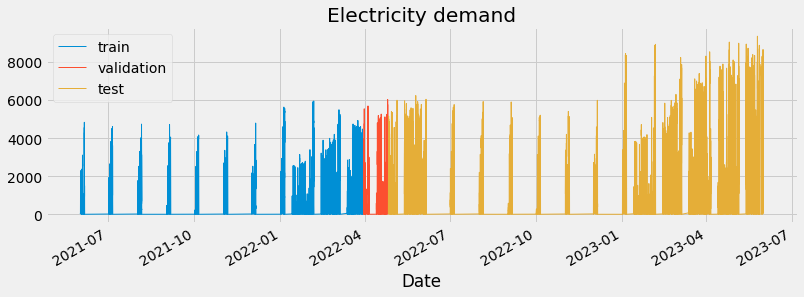

In [44]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.Valeur.plot(ax=ax, label='train', linewidth=1)
data_val.Valeur.plot(ax=ax, label='validation', linewidth=1)
data_test.Valeur.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

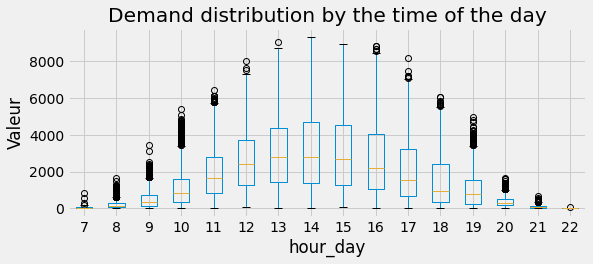

In [45]:


# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
data['hour_day'] = data.index.hour + 1 
data.boxplot(column='Valeur', by='hour_day', ax=ax)
#data.groupby('hour_day')['Valeur'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Valeur')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('');



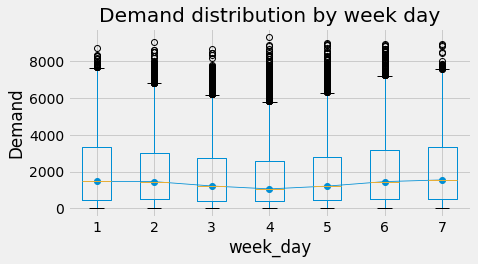

In [46]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Valeur', by='week_day', ax=ax)
data.groupby('week_day')['Valeur'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

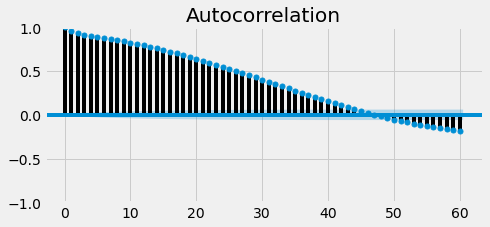

In [47]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data.Valeur, ax=ax, lags=60)
plt.show()

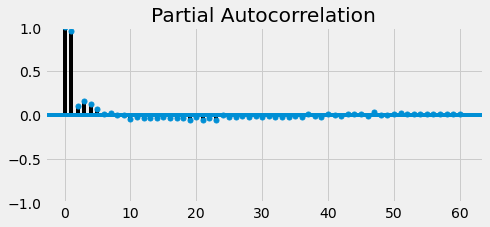

In [48]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data.Valeur, ax=ax, lags=60)
plt.show()



Forecaster training¶


In [49]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
             )

forecaster.fit(y=data.loc[:end_validation, 'Valeur'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 14237] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-07-20 15:56:17 
Last fit date: 2022-07-20 15:56:17 
Skforecast version: 0.4.3 

In [50]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data.Valeur,
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                       )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 14238
Number of observations used for backtesting: 22577
    Number of folds: 941
    Number of steps per fold: 24
    Last fold only includes 17 observations

Data partition in fold: 0
    Training:   2023-01-01 08:00:00 -- 2022-01-01 11:02:00
    Validation: 2022-01-01 11:07:00 -- 2022-01-01 13:12:00
Data partition in fold: 1
    Training:   2023-01-01 08:00:00 -- 2022-01-01 11:02:00
    Validation: 2022-01-01 13:22:00 -- 2022-01-01 15:42:00
Data partition in fold: 2
    Training:   2023-01-01 08:00:00 -- 2022-01-01 11:02:00
    Validation: 2022-01-01 15:47:00 -- 2022-02-01 09:27:00
Data partition in fold: 3
    Training:   2023-01-01 08:00:00 -- 2022-01-01 11:02:00
    Validation: 2022-02-01 09:37:00 -- 2022-02-01 11:42:00
Data partition in fold: 4
    Training:   2023-01-01 08:00:00 -- 2022-01-01 11:02:00
    Validation: 2022-02-01 11:47:00 --

In [51]:
predictions

,pred
24,1718.061053
25,1777.420358
26,1846.596541
27,1913.713460
28,1972.152046
...,...
36,629.529461
37,664.717959
38,701.298955
39,732.515927


In [75]:
predictions.index



RangeIndex(start=0, stop=22577, step=1)

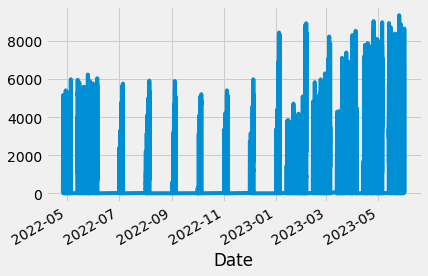

In [82]:
# Plot
# ==============================================================================
v = predictions.index

data.loc[end_validation:,'Valeur'].plot()

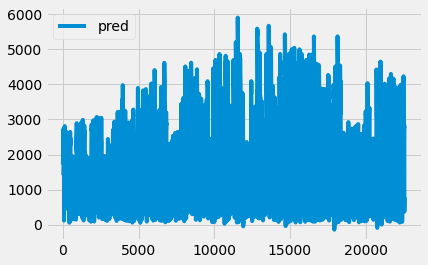

In [83]:
predictions.plot()

In [188]:
def backtest_predict_next_24h(forecaster, y, hour_init_prediction, exog=None,
                              verbose=False):
    
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg 
        ForecasterAutoreg object already trained.
        
    y : pd.Series with datetime index sorted
        Test time series values. 
        
    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable. 
    
    hour_init_prediction: int 
        Hour of day D to start predicciones of day D+1.


    Returns 
    -------
    predicciones: pd.Series
        Value of predicciones.

    '''
    
    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()
        
    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24
    
    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break
    
    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predicciones = []
    
    for i, day in enumerate(days_backtest):        
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]
               
        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")
                
            pred = forecaster.predict(steps=steps, last_window=last_window)
            
        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window
            
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")
            
            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predicciones of day D+1
        pred = pred[dummy_steps:]
        backtest_predicciones.append(pred)
    
    backtest_predicciones = np.concatenate(backtest_predicciones)
    # Add datetime index
    backtest_predicciones = pd.Series(
                             data  = backtest_predicciones,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )
    
    return backtest_predicciones

In [193]:


# Backtest
# ==============================================================================
predictions = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = data.loc[end_validation:, 'Valeur'],
                    hour_init_prediction = 24,
                    verbose    = False
              )



UnboundLocalError: ignored